# Webscraping from CDC COVID-19 Site and Creating Plot
- Patty Jula, author

The CDC has been providing daily counts of the number of cases and deaths in the United States from COVID-19. This script provides a way to download the day's counts, load to a database, in this case a CSV, and create a plot. 
## Note:
This type of webscraping is only available from sites that reveal their source code. The best practice is to ask permission before scraping so an organization's servers are not overloaded.

In [216]:
# Dependencies
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
import numpy as np
import matplotlib.ticker as mtick

In [217]:
# Boilerplate code
url = 'http://www.cdc.gov/coronavirus/2019-ncov/cases-updates/cases-in-us.html'
res = requests.get(url)
html_page = res.content

## Parse through the html

In [218]:
soup = BeautifulSoup(html_page, 'html.parser')
#print(soup.prettify())

## Load data to a Pandas dataframe

In [219]:

column = ['Prelim']


data = []
data_raw = soup.find("div", {"class": "card-body bg-white"}).findAll('ul')
#print(data_raw)
for row in data_raw:
    items = []
    data = []
    x = 1
    for element in row.findAll('li'):
        if x <= 1:
            print(element.text)
            items.append(element.text)
            data.append(element.text)
        else:
            break
        x =+ 1
        #data.append(items)
        #print(data)

df = pd.DataFrame(data, columns=column)
#df.head()

Total cases: 186,101
Total deaths: 3,603
Jurisdictions reporting cases: 55 (50 states, District of Columbia, Puerto Rico, Guam, the Northern Mariana Islands, and the U.S. Virgin Islands)


## Format dataframe

In [220]:
df['type'] =  df['Prelim'].str.split(':').str[0]
df['count'] =  df['Prelim'].str.split(':').str[1]
df = df.drop(df.index[2])
del df['Prelim']
df.head()

,type,count
0,Total cases,"186,101"
1,Total deaths,"3,603"


## Add day's date to dataframe

In [221]:
import datetime
def today_date():
    '''
    utils:
    get the datetime of today
    '''
    date=datetime.datetime.now().date()
    date=pd.to_datetime(date)
    return date
df['Date'] = today_date()


# Additional data wrangling

## Explicitly convert Dat field to date

In [222]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['count'] = df['count'].str.replace(',', '').astype(int)
df.head()

,type,count,Date
0,Total cases,186101,2020-04-01
1,Total deaths,3603,2020-04-01


## Now let's deal with existing database

In [223]:

dfDB = pd.read_csv("storage.csv", parse_dates=['Date'], dayfirst=True)
dfDB.set_index('Date')
dfDB.head()

,Date,Unnamed: 0,count,type
0,2020-03-27,2.0,85356,Total cases
1,2020-03-27,3.0,1246,Total deaths
2,2020-03-31,0.0,163539,Total cases
3,2020-03-31,1.0,2860,Total deaths
4,2020-04-01,NaN,186101,Total cases


## If current day's date is already in database, delete it

In [224]:
for index, row in dfDB.iterrows():
    #print(row['Date'])
    if row['Date'] == today_date():
        print('Found')
        dfDB.drop(index, inplace=True)
    else:
        pass

Found
Found


## Then let's add the newly scraped data to the database

In [225]:
df= dfDB.append(df, ignore_index = True,sort=True)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.sort_values(by='Date',ascending=True)
#del df['Unnamed: 0']
df.head(10)

,Date,Unnamed: 0,count,type
0,2020-03-27,2.0,85356,Total cases
1,2020-03-27,3.0,1246,Total deaths
2,2020-03-31,0.0,163539,Total cases
3,2020-03-31,1.0,2860,Total deaths
4,2020-04-01,NaN,186101,Total cases
5,2020-04-01,NaN,3603,Total deaths


In [226]:
df.to_csv("storage.csv", encoding='utf-8', index=False)

## Again, explicitly set date

In [227]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Create plot with seaborn

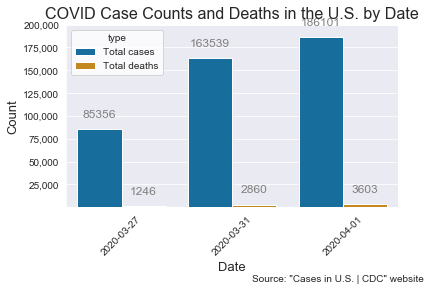

In [228]:
#sns.set(style="whitegrid")
sns.set_style('darkgrid')
fig, ax = plt.subplots()
rcParams['figure.figsize'] = 11.7,8.27
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# bar lot
ax = sns.barplot(x="Date", y="count", hue= 'type', data=df, palette ="colorblind")#, color= 'Set2')
# Label values
# "%.0f"
for p in ax.patches:
    #y = int("count")
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='center', fontsize=12, color='gray', xytext=(0, 15),
        textcoords='offset points')
sns.color_palette("Set2")
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=45)
plt.title("COVID Case Counts and Deaths in the U.S. by Date", size = 16)
plt.xlabel("Date", size = 13)
plt.ylabel("Count", size = 13)
plt.tight_layout()
ax.set(ylim=(10, 200000))
plt.figtext(0.99, 0.01, 'Source: "Cases in U.S. | CDC" website', horizontalalignment='right') 
plt.savefig('data.png', dpi=600) 
plt.show()